Implementation to create the dataframe and train the model\
Authors: \
*   Mani Smaran Nair
*   Maria Mathews



In [ ]:
!pip install git+https://github.com/huggingface/transformers.git@main

  Cloning https://github.com/huggingface/transformers.git (to revision main) to /tmp/pip-req-build-582no5zr
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-582no5zr
  Resolved https://github.com/huggingface/transformers.git to commit a3aabc702e1c49243e7b48f22d88362d50e786c5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.41.0.dev0-py3-none-any.whl size=9044556 sha256=8833f46e7d5ee833165acba86d6cb00605d02dedd96782a32514e869d44e37ab
  Stored in directory: /tmp/pip-ephem-wheel-cache-738unoae/wheels/cf/59/82/6492402e887a68975030bf8c06532260abc16abb7ccd8127cc
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.0
    Uninstalling transformers-4.40.0:
      Successfully uninstalled transformers-4.40.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
root_dir = "/content/gdrive/"

Mounted at /content/gdrive/


In [ ]:
'''
#Smaran's link :
!unzip /content/gdrive/MyDrive/BLIP/all_food_train2017.zip
'''

#Maria's link:
!unzip /content/gdrive/MyDrive/Cake_Captioning/cake_coco/cake_image_train2017.zip


Archive:  /content/gdrive/MyDrive/Cake_Captioning/cake_coco/cake_image_train2017.zip
  inflating: cake_image_train2017/000000000092.jpg  
  inflating: cake_image_train2017/000000000113.jpg  
  inflating: cake_image_train2017/000000000127.jpg  
  inflating: cake_image_train2017/000000000428.jpg  
  inflating: cake_image_train2017/000000000735.jpg  
  inflating: cake_image_train2017/000000000790.jpg  
  inflating: cake_image_train2017/000000000982.jpg  
  inflating: cake_image_train2017/000000001180.jpg  
  inflating: cake_image_train2017/000000001261.jpg  
  inflating: cake_image_train2017/000000001290.jpg  
  inflating: cake_image_train2017/000000001424.jpg  
  inflating: cake_image_train2017/000000001522.jpg  
  inflating: cake_image_train2017/000000001667.jpg  
  inflating: cake_image_train2017/000000001688.jpg  
  inflating: cake_image_train2017/000000001813.jpg  
  inflating: cake_image_train2017/000000002411.jpg  
  inflating: cake_image_train2017/000000002525.jpg  
  inflating: c

In [ ]:
import os
import json
import csv
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader

In [ ]:
#Uncomment own path and comment the other one's path
#All folder/file path
'''
# Smaran's:
image_folder = "/content/samplefood"
json_file = "/content/samplefoodcaptions.json"
output_csv_file = "output_dataset.csv"
'''


#Maria's:
image_folder = '/content/cake_image_train2017'
caption_file = '/content/all_food_captions_train2017.json'
output_csv_file = "/content/output_dataset.csv"



In [ ]:
#Loading the captions to image_map
image_map = None
#Give the path to your captions file here:
with open(caption_file, 'r') as f:
    image_map = json.load(f)

In [ ]:
#Run this ONLY IF you are using AUGMENTED dataset:. Otherwise run the next code cell
#The logic handles filenames for synthetic images as well.
#Logic to fetch the 5 captions for each cake image in augmented dataset

# Initialize an empty dictionary
image_captions = {}

for filename in os.listdir(image_folder):
    if filename.endswith(".jpg"):
        # Extract image ID (filename without extension)
        image_id = os.path.splitext(filename)[0]

        # Convert first digit of image ID from 1 to 0
        if image_id.startswith("1"):
            image_id = "0" + image_id[1:]

        # Extract captions for the image ID from captions_data
        captions = [caption_entry["caption"] for caption_entry in image_map if caption_entry["image_id"] == int(image_id)]

        image_captions[filename] = captions

In [ ]:
#Run this ONLY IF you are using ORIGINAL dataset
#Logic to fetch the 5 captions for each cake image

# Initialize an empty dictionary
image_captions = {}

for filename in os.listdir(image_folder):
    if filename.endswith(".jpg"):
      # Extract image ID (filename without extension)
        image_id = os.path.splitext(filename)[0]
        # Extract captions for the image ID from captions_data
        captions = [caption_entry["caption"] for caption_entry in image_map if caption_entry["image_id"] == int(image_id)]
        image_captions[filename] = captions

In [ ]:
# Process the images
images = []
names_image = []
image_paths = []

# Iterate over images in the directory
for filename in os.listdir(image_folder):
    if filename.endswith(".jpg"):
      try:
        # Load image
        image_path = os.path.join(image_folder, filename)
        image = Image.open(image_path).convert('RGB')
        image = image.resize((224, 224))
        images.append(image)
        names_image.append(filename)
        image_paths.append(image_path)
      except OSError as e:
        print(f"Error processing {filename}: {e}")
            # Optionally, you can choose to skip this image
        continue


000000061647.jpg
/content/cake_image_train2017/000000061647.jpg


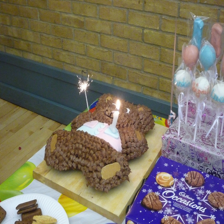

In [ ]:
print(names_image[0])
print(image_paths[0])
display(images[0])
print(image_captions[names_image[0]])
print(image_captions["000000007733.jpg"])
print(image_captions[names_image[0]][0])

In [ ]:
print(len(images))

['a teddy bear shaped cake resting on a cutting board', 'The cake is shaped like a teddy bear.', 'A teddy bear cake with a candle and sparklers.', 'A bear shaped cake with lit candles inserted.', 'A cake shaped like a bear has a sparkler and candle on it.']
['A bride and a groom feeding cake to each other.', 'two people feeding each other cake with their hands', 'A man and a woman are feeding each other cake with their hands.', 'A man and woman are each feeding each ither a piece of cake.', 'A man and woman are feeding each other cake.']
a teddy bear shaped cake resting on a cutting board
2925


In [ ]:
#Creating the dataframe

x = range(len(image_captions))

# Create an empty list to store data for each row {image, caption1, cpation2,... caption5}
data = []

#df.set_index('index', inplace=True)
for image_name, captions in image_captions.items():

  image_path = os.path.join(image_folder, image_name)
  image = Image.open(image_path).convert('RGB')
  image = image.resize((224, 224))
  row = {'Image': image , 'Caption_1': captions[0], 'Caption_2': captions[1], 'Caption_3': captions[2], 'Caption_4': captions[3], 'Caption_5': captions[4]}
  data.append(row)
# Convert the 'data' list into a DataFrame
org_df = pd.DataFrame(data)

# Save DataFrame to CSV file
org_df.to_csv(output_csv_file)

In [ ]:
type(org_df['Image'][0])

PIL.Image.Image

In [ ]:
df = pd.read_csv(output_csv_file)

In [ ]:
print(df.dtypes)
print(org_df.dtypes)

Unnamed: 0     int64
Image         object
Caption_1     object
Caption_2     object
Caption_3     object
Caption_4     object
Caption_5     object
dtype: object
Image        object
Caption_1    object
Caption_2    object
Caption_3    object
Caption_4    object
Caption_5    object
dtype: object


In [ ]:
org_df.head()

,Image,Caption_1,Caption_2,Caption_3,Caption_4,Caption_5
0,<PIL.Image.Image image mode=RGB size=224x224 a...,A bride and a groom feeding cake to each other.,two people feeding each other cake with their ...,A man and a woman are feeding each other cake ...,A man and woman are each feeding each ither a ...,A man and woman are feeding each other cake.
1,<PIL.Image.Image image mode=RGB size=224x224 a...,a close up of a dog laying on a chair,A dog sitting in front of celebratory doggy tr...,A black and brown dog sitting on a blue chair ...,a brown and black dog is sitting on a pillow o...,A dog sitting on a chair with two dishes in fr...
2,<PIL.Image.Image image mode=RGB size=224x224 a...,a baby laughs while sitting at a table,A baby sitting at a table with a plate of food.,A smiling baby in a high chair next to a dish.,A smiling baby sitting on someone's lap and re...,A baby in white shirt at table with food in th...
3,<PIL.Image.Image image mode=RGB size=224x224 a...,a person that has a lighter in their hand,Someone is lighting a birthday candle on top o...,A pineapple cake with a 30 candle is being lit.,A person lighting a 30th birthday candle on a ...,the person is lighting a cake with candles on it
4,<PIL.Image.Image image mode=RGB size=224x224 a...,Baker proudly displays her white dog cake in h...,A woman wearing an apron standing next to a ca...,A woman standing next to a cake in the shape ...,A woman standing next to a dog cake.,A woman standing next to a cake shaped like a ...


In [ ]:
df.head()

,Unnamed: 0,Image,Caption_1,Caption_2,Caption_3,Caption_4,Caption_5
0,0,<PIL.Image.Image image mode=RGB size=224x224 a...,A bride and a groom feeding cake to each other.,two people feeding each other cake with their ...,A man and a woman are feeding each other cake ...,A man and woman are each feeding each ither a ...,A man and woman are feeding each other cake.
1,1,<PIL.Image.Image image mode=RGB size=224x224 a...,a close up of a dog laying on a chair,A dog sitting in front of celebratory doggy tr...,A black and brown dog sitting on a blue chair ...,a brown and black dog is sitting on a pillow o...,A dog sitting on a chair with two dishes in fr...
2,2,<PIL.Image.Image image mode=RGB size=224x224 a...,a baby laughs while sitting at a table,A baby sitting at a table with a plate of food.,A smiling baby in a high chair next to a dish.,A smiling baby sitting on someone's lap and re...,A baby in white shirt at table with food in th...
3,3,<PIL.Image.Image image mode=RGB size=224x224 a...,a person that has a lighter in their hand,Someone is lighting a birthday candle on top o...,A pineapple cake with a 30 candle is being lit.,A person lighting a 30th birthday candle on a ...,the person is lighting a cake with candles on it
4,4,<PIL.Image.Image image mode=RGB size=224x224 a...,Baker proudly displays her white dog cake in h...,A woman wearing an apron standing next to a ca...,A woman standing next to a cake in the shape ...,A woman standing next to a dog cake.,A woman standing next to a cake shaped like a ...


Let's retrieve the image of the first example:

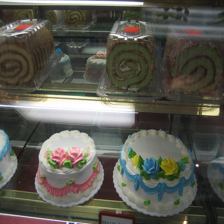

In [ ]:
org_df['Image'][8]

And the corresponding text

In [ ]:
print(org_df['Caption_1'][8])
print(org_df['Caption_2'][8])
print(org_df['Caption_3'][8])
print(org_df['Caption_4'][8])
print(org_df['Caption_5'][8])

A display case in a bakery with decorated cakes and cream rolls.
Cakes are shown in a display case at a store.
A case that has a couple of cakes inside of it.
Cakes sit next to each other in a display case. 
A bakery case filled with various decorated cakes


## Load the dataset


In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and combined validation-test subsets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [ ]:
##Creating the dataset

class PandasDataset(Dataset):
    def __init__(self, dataframe,processor, tokenizer):
        self.dataframe = dataframe
        self.processor = processor
        self.tokenizer = tokenizer
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        item = self.dataframe.iloc[index]
        image = item['Image']  # Extracting image from DataFrame
        #print(image)
        #print(type(image))
        caption = item['Caption_1']  # Extracting caption from DataFrame
        #image_path = os.path.join(image_folder, image_name)
        #image = Image.open(image).convert("RGB")  # Ensure image is in RGB mode
        #image_tensor = torch.tensor(np.array(image))  # Convert PIL Image to numpy array, then to torch tensor
        encoding = self.processor(images=image, text=caption, padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["Caption_1"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    #print('collated')
    return processed_batch


## Load model and processor

In [ ]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Now that we have loaded the processor, let's load the dataset and the dataloader:

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
train_dataset = PandasDataset(org_df, processor, tokenizer)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2,  collate_fn=collate_fn)

## Model Training

In [ ]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

loss_values = []

for epoch in range(2):
  print("Epoch:", epoch)

  for idx, batch in enumerate(train_dataloader):
      input_ids = batch.pop('input_ids').to(device)
      pixel_values = batch.pop('pixel_values').to(device)

      outputs = model(input_ids=input_ids,
                      pixel_values=pixel_values,
                      labels=input_ids)

      loss = outputs.loss
      loss_values.append(loss.item())
      print("Loss:", loss.item())

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

Epoch: 0
Loss: 6.310176849365234
Loss: 6.360404014587402
Loss: 6.112364292144775
Loss: 5.899192810058594
Loss: 5.813516616821289
Loss: 5.696234703063965
Loss: 5.550601482391357
Loss: 5.4083757400512695
Loss: 5.349926471710205
Loss: 5.174715995788574
Loss: 5.055972576141357
Loss: 4.958427906036377
Loss: 4.811193943023682
Loss: 4.734219551086426
Loss: 4.568330764770508
Loss: 4.4728522300720215
Loss: 4.401318550109863
Loss: 4.228231906890869
Loss: 4.109302043914795
Loss: 3.995396137237549
Loss: 3.8700568675994873
Loss: 3.7669107913970947
Loss: 3.629202365875244
Loss: 3.5281026363372803
Loss: 3.4049649238586426
Loss: 3.301175594329834
Loss: 3.173792839050293
Loss: 3.0295333862304688
Loss: 2.9325382709503174
Loss: 2.814297676086426
Loss: 2.699521064758301
Loss: 2.620831251144409
Loss: 2.4625885486602783
Loss: 2.3687355518341064
Loss: 2.2321996688842773
Loss: 2.1478404998779297
Loss: 2.042646646499634
Loss: 1.9233416318893433
Loss: 1.851367712020874
Loss: 1.7121440172195435
Loss: 1.616238117

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [ ]:
#Save your model. Make sure to give appropriate name for the saved model
model.save_pretrained("/content/gdrive/MyDrive/Cake_Captioning/cake_caption_model2.9k")